In [1]:
import json
# facilitate imports from project root
import sys
sys.path.append("..")

In [2]:
from chase_rank.match import match_track
from chase_rank.process import process_match

In [3]:
from pathlib import Path

import gpxpy
import overpy

import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import LineString, Point
from routingpy import Valhalla

In [4]:
DATA_PATH = Path("../data")
TEST_TRACK_PATH = Path(DATA_PATH, "routes/test_track.gpx")

VALHALLA_CLIENT = Valhalla(base_url="http://127.0.0.1:8002")
OVERPASS_API = overpy.Overpass()

---
# Datei Laden

In [5]:
with open(TEST_TRACK_PATH) as file_pointer:
    gpx_content = gpxpy.parse(file_pointer)

gpx_data = []
gpx_geometry = []
for point in gpx_content.tracks[0].segments[0].points:
    gpx_geometry.append(Point(point.longitude, point.latitude))
    gpx_data.append({
        # clear tzinfo until it can be handled for the match query
        "time": point.time.replace(tzinfo=None),
        "elev": point.elevation,
        "longitude": point.longitude,
        "latitude": point.latitude
    })

gpx_frame = gpd.GeoDataFrame(
    gpx_data, geometry=gpx_geometry, crs="EPSG:4326").to_crs("EPSG:3857")
# search for splits in the trace bigger than 1s and label consecutive sections
gpx_frame["section"] = (gpx_frame["time"].diff() != pd.Timedelta("1 second")).cumsum()

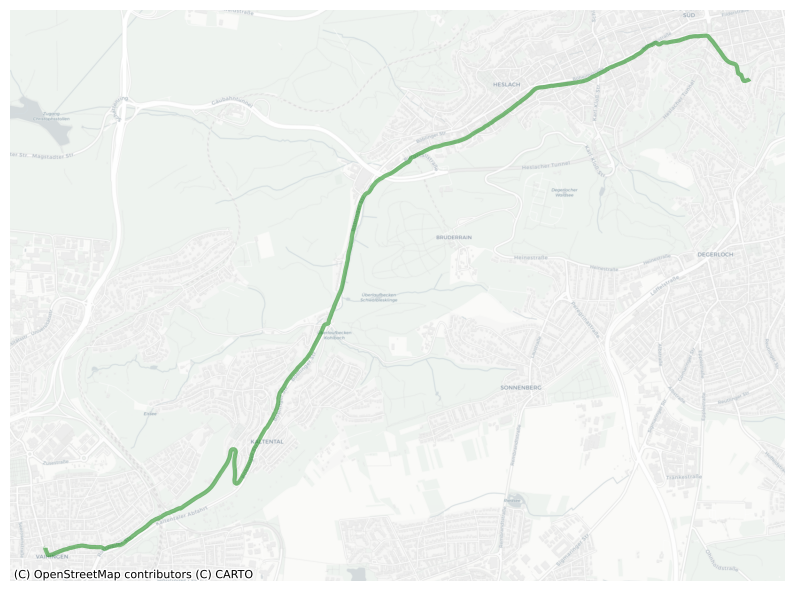

In [6]:
import contextily as cx

fig, ax = plt.subplots(1,1, figsize=(10,10))
gpd.GeoDataFrame(geometry=[LineString(gpx_frame["geometry"])]).plot(
    ax=ax, color="green", linewidth=3, alpha=0.5)
cx.add_basemap(ax=ax, crs="EPSG:3857", source=cx.providers.CartoDB.Positron)
_ = ax.axis("off")

---
# Matching

In [7]:
trace_df, edges_df = match_track(gpx_frame)

In [8]:
pdf = process_match(gpx_frame, trace_df, edges_df)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Pseudo-Mercator (the single non-null crs provided).
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Pseudo-Mercator (the single non-null crs provided).
  warnings.warn(


TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''